In [3]:
# ! pip install optuna

In [303]:
#pip install pytorch_optimizer

In [304]:
#pip install xgboost

In [305]:
#pip uninstall torchvision -y

In [306]:
#pip install torchvision==0.23

In [307]:
#pip uninstall pandas -y

In [308]:
#pip install -U pandas

In [309]:
#pip install -U numexpr

In [310]:
#pip install numpy==1.26.4

In [118]:
import warnings
warnings.filterwarnings("ignore", message="Choices for a categorical distribution should be a tuple")
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended")
warnings.filterwarnings("ignore", message="IProgress not found")

import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler

import optuna
import numpy as np
import pandas as pd
from scipy.special import softmax, expit

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve, CalibrationDisplay

from collections import Counter

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../../')
from torchlogic.models import BanditNRNClassifier
from torchlogic.utils.trainers import BanditNRNTrainer

In [311]:
import torch
torch.__version__

'2.8.0+cu128'

In [2]:
!conda env list

# conda environments:
#
base                     /home/khamilton/anaconda3
domains                  /home/khamilton/anaconda3/envs/domains
tl                    *  /home/khamilton/anaconda3/envs/tl
transformers             /home/khamilton/anaconda3/envs/transformers



In [7]:
import numpy as np
import pandas as pd
import sklearn
import optuna
import scipy
import matplotlib
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(optuna.__version__)
print(scipy.__version__)
print(matplotlib.__version__)

1.26.4
2.3.1
1.6.1
2.10.1
1.7.1
3.4.3


In [3]:
# !python -c "import sklearn; sklearn.show_versions()"

In [5]:
# # If we want the logs from Bandit-RRN training

# from carrot.logger import Logger

# log_config = 'configs/logging.yaml'
# log_dir = 'logs'
# logger = Logger.get(log_config, log_dir)

# TODO: 
### Get time-series data from LBNL (Lawrence Berkeley National Laboratory)
DOI: 10.25984/1881324

# Get kaggle timeseries IoT data

About this file

This file contains real-time IoT sensor data collected from industrial machines for predictive maintenance and anomaly detection in smart manufacturing systems. The dataset includes sensor readings, machine status, failure types, and a target column (maintenance_required), which indicates whether a machine requires maintenance.

File Contents:

* Timestamps – Time at which the sensor readings were recorded
* Machine ID – Unique identifier for each machine
* Sensor Readings – Temperature, Vibration, Humidity, Pressure, Energy Consumption
* Machine Status – Indicates whether the machine is Idle, Running, or in Failure
* Anomaly Flags – Identifies extreme values in temperature and vibration
* Predicted Remaining Life – Estimated time before maintenance is needed
* Failure Type – The reason for machine failure (e.g., Overheating, Vibration Issue)
* Downtime Risk Score – Probability of machine breakdown
* Maintenance Required (maintenance_required) – Target column (0 = No, 1 = Yes)

Purpose of This File:

* 📌 Train Machine Learning Models for predictive maintenance
* 📌 Detect Anomalies in smart manufacturing environments
* 📌 Optimize IoT-driven industrial processes

In [312]:
#pip install kagglehub

In [10]:
import kagglehub

# Download latest version
# https://www.kaggle.com/datasets/ziya07/smart-manufacturing-iot-cloud-monitoring-dataset
path = kagglehub.dataset_download("ziya07/smart-manufacturing-iot-cloud-monitoring-dataset")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1.83M/1.83M [00:00<00:00, 3.64MB/s]

Extracting files...
Path to dataset files: /home/khamilton/.cache/kagglehub/datasets/ziya07/smart-manufacturing-iot-cloud-monitoring-dataset/versions/1


In [38]:
ls {path}

smart_manufacturing_data.csv


In [40]:
df = pd.read_csv(path+"/smart_manufacturing_data.csv")

In [41]:
df.head()

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 00:00:00,39,78.61,28.65,79.96,3.73,2.16,1,0,106,Normal,0.0,0
1,2025-01-01 00:01:00,29,68.19,57.28,35.94,3.64,0.69,1,0,320,Normal,0.0,0
2,2025-01-01 00:02:00,15,98.94,50.20,72.06,1.00,2.49,1,1,19,Normal,1.0,1
3,2025-01-01 00:03:00,43,90.91,37.65,30.34,3.15,4.96,1,1,10,Normal,1.0,1
4,2025-01-01 00:04:00,8,72.32,40.69,56.71,2.68,0.63,2,0,65,Vibration Issue,0.0,1


In [314]:
Counter(df["failure_type"])

Counter({'Normal': 91899,
         'Vibration Issue': 3129,
         'Overheating': 1989,
         'Pressure Drop': 1969,
         'Electrical Fault': 1014})

In [313]:
Counter(df["machine_id"])

Counter({39: 1993,
         29: 2044,
         15: 2027,
         43: 1906,
         8: 1967,
         21: 2052,
         19: 2004,
         23: 2092,
         11: 1951,
         24: 1984,
         36: 2085,
         40: 2001,
         3: 2001,
         22: 2031,
         2: 2041,
         44: 2054,
         30: 2074,
         38: 2058,
         33: 1956,
         12: 1955,
         25: 1998,
         49: 1950,
         27: 1957,
         42: 2019,
         28: 2048,
         16: 2010,
         47: 2001,
         37: 1964,
         7: 1965,
         9: 1991,
         18: 2031,
         4: 2004,
         14: 1941,
         50: 1912,
         26: 2059,
         20: 1970,
         35: 1913,
         17: 2061,
         6: 1934,
         34: 1948,
         10: 2022,
         31: 1933,
         48: 2058,
         45: 2080,
         41: 2013,
         1: 1916,
         5: 2043,
         13: 2040,
         32: 2031,
         46: 1912})

In [44]:
m39 = df[df["machine_id"]==39]
m39.head()

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 00:00:00,39,78.61,28.65,79.96,3.73,2.16,1,0,106,Normal,0.0,0
6,2025-01-01 00:06:00,39,73.05,40.70,61.59,2.35,1.63,1,0,470,Normal,0.0,0
42,2025-01-01 00:42:00,39,78.29,39.54,36.67,3.31,4.44,1,0,298,Normal,0.0,0
114,2025-01-01 01:54:00,39,79.06,37.46,45.55,2.48,4.59,1,0,398,Normal,0.0,0
143,2025-01-01 02:23:00,39,72.27,40.70,65.42,2.97,4.73,0,0,66,Normal,0.0,0


In [46]:
Counter(m39["failure_type"])

Counter({'Normal': 1833,
         'Vibration Issue': 68,
         'Pressure Drop': 39,
         'Overheating': 31,
         'Electrical Fault': 22})

In [47]:
Counter(m39["anomaly_flag"])

Counter({0: 1836, 1: 157})

In [50]:
Counter(m39["maintenance_required"])

Counter({0: 1607, 1: 386})

In [51]:
m39.columns

Index(['timestamp', 'machine_id', 'temperature', 'vibration', 'humidity',
       'pressure', 'energy_consumption', 'machine_status', 'anomaly_flag',
       'predicted_remaining_life', 'failure_type', 'downtime_risk',
       'maintenance_required'],
      dtype='object')

In [332]:
X = df[['temperature', 'vibration', 'humidity',
       'pressure', 'energy_consumption', 'machine_status']]
y = df['failure_type'].apply(lambda x: 0 if x=='Normal' else 1)

In [333]:
X.to_numpy()

array([[78.61, 28.65, 79.96,  3.73,  2.16,  1.  ],
       [68.19, 57.28, 35.94,  3.64,  0.69,  1.  ],
       [98.94, 50.2 , 72.06,  1.  ,  2.49,  1.  ],
       ...,
       [93.01, 51.79, 64.28,  4.04,  3.62,  1.  ],
       [84.41, 22.35, 35.18,  2.88,  2.37,  1.  ],
       [73.53, 67.09, 74.35,  2.15,  2.5 ,  1.  ]])

In [334]:
features = X.columns

# Load Data

In [335]:
data = {'data':X.to_numpy(),
        'target':y.to_numpy(),
        'target_names':['no','yes'],
        'feature_names':X.columns}


In [336]:
from types import SimpleNamespace
data = SimpleNamespace(**data)
print(type(data))
data

<class 'types.SimpleNamespace'>


namespace(data=array([[78.61, 28.65, 79.96,  3.73,  2.16,  1.  ],
                      [68.19, 57.28, 35.94,  3.64,  0.69,  1.  ],
                      [98.94, 50.2 , 72.06,  1.  ,  2.49,  1.  ],
                      ...,
                      [93.01, 51.79, 64.28,  4.04,  3.62,  1.  ],
                      [84.41, 22.35, 35.18,  2.88,  2.37,  1.  ],
                      [73.53, 67.09, 74.35,  2.15,  2.5 ,  1.  ]]),
          target=array([0, 0, 0, ..., 0, 0, 0]),
          target_names=['no', 'yes'],
          feature_names=Index(['temperature', 'vibration', 'humidity', 'pressure',
                               'energy_consumption', 'machine_status'],
                              dtype='object'))

# Prepare Bandit-RRN Data

A dataset for the Bandit-RRN algorithm in torchlogic must return a dictionary of the following form:

```python
{
    'features': [N_FEATURES], 'target': [N_TARGETS], 'sample_idx': [1]
}
```

- The `features` key contains a tensor of the features used for prediction.  Feature must be numeric and scaled between 0 and 1.

- The `target` key must contain a tensor of the targets, with the values of 0 or 1 for each target.

- The `sample_idx` key must contain a tensor of the row number in the data corresponding to that sample.

## Preprocess Data

In [337]:
mms = MinMaxScaler()
X = mms.fit_transform(data.data)

In [338]:
y = data.target.reshape(-1, 1)

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42)

In [340]:
len(y_train)

70200

## Define PyTorch Dataset

In [341]:
class BanditNRNDataset(Dataset):
    def __init__(
            self,
            X: np.array,
            y: np.array
    ):
        """
        Dataset suitable for BanditRRN model from torchlogic

        Args:
            X (np.array): features data scaled to [0, 1]
            y (np.array): target data of classes 0, 1
        """
        super(BanditNRNDataset, self).__init__()
        self.X = X
        self.y = y
        self.sample_idx = np.arange(X.shape[0])  # index of samples

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        features = torch.from_numpy(self.X[idx, :]).float()
        target = torch.from_numpy(self.y[idx, :])
        return {'features': features, 'target': target, 'sample_idx': idx}

## Instantiate Datasets and Data Loaders

In [342]:
train_dataset = BanditNRNDataset(X=X_train, y=y_train)
val_dataset = BanditNRNDataset(X=X_val, y=y_val)
test_dataset = BanditNRNDataset(X=X_test, y=y_test)

In [343]:
type(train_dataset)

__main__.BanditNRNDataset

In [344]:
train_dataset.__getitem__(0)

{'features': tensor([0.5001, 0.4481, 0.4978, 0.0900, 0.2911, 0.5000]),
 'target': tensor([0]),
 'sample_idx': 0}

In [345]:
g = torch.Generator()
g.manual_seed(0)

def create_holdout_samplers(train_dataset, pct=0.2):
    train_size = len(train_dataset)
    indices = list(range(train_size))
    np.random.seed(0)
    np.random.shuffle(indices)
    
    train_holdout_split_index = int(np.floor(pct * train_size))
    train_idx, train_holdout_idx = indices[train_holdout_split_index:], indices[:train_holdout_split_index]
    
    train_sampler = SubsetRandomSampler(train_idx)
    train_holdout_sampler = SubsetRandomSampler(train_holdout_idx)
    
    return train_sampler, train_holdout_sampler

train_sampler, train_holdout_sampler = create_holdout_samplers(train_dataset)

train_dl = DataLoader(
    train_dataset, batch_size=32, generator=g, sampler=train_sampler,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
train_holdout_dl = DataLoader(
    train_dataset, batch_size=32, generator=g, sampler=train_holdout_sampler,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
val_dl = DataLoader(
    val_dataset, batch_size=32, generator=g, 
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
test_dl = DataLoader(
    test_dataset, batch_size=32, generator=g, 
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)

# Train Bandit-RRN Model

## Prepare the Feature Names

To aid in the explantions of our model, we can set our feature names to natural language that represents the values of the feature.
In the current data, each feature represents a measurement in centimeters and is scaled between 0 to 1, so represents a percentile.
We rename each feature to describe this represenation of our data, which is then used when extracting explanations from the model.

In [346]:
data.feature_names = [f"the {x} was" for x in features]

In [349]:
data.feature_names

['the temperature was',
 'the vibration was',
 'the humidity was',
 'the pressure was',
 'the energy_consumption was',
 'the machine_status was']

## Tune Hyper-parameters

In [350]:
torch.random.manual_seed(0)
np.random.seed(0)

class TuneParameters:
    
    def __init__(self, n_trials=10):
        self.best_model = None
        self.best_rn_val_performance = 0.0
        self.n_trials = n_trials

    def _objective(self, trial):

        ########################################################################################################################
        # NOTE: These hyper-parameter settings are specific to the breast cancer dataset.  For information on generally useful
        # ranges of hyper-parameters and their descriptions see our documentation: 
        ########################################################################################################################

        # Set Parameters
        
        ## Reinforced Reasoning Network Parameters
        layer_sizes = trial.suggest_categorical('layer_sizes', [(2, ), (3, ), (5, ), (10, ), 
                                                                (2, 2), (3, 3), (5, 5), (10, 10)])
        n_selected_features_input = trial.suggest_int('n_selected_features_input', low=2, high=3)
        n_selected_features_internal = trial.suggest_int('n_selected_features_internal', low=2, high=min(3, min(layer_sizes)))
        n_selected_features_output = trial.suggest_int('n_selected_features_output', low=2, high=min(3, layer_sizes[-1]))
        perform_prune_plateau_count = trial.suggest_int('perform_prune_plateau_count', low=1, high=1)
        perform_prune_quantile = trial.suggest_float('perform_prune_quantile', low=0.1, high=0.9)
        increase_prune_plateau_count = trial.suggest_int('increase_prune_plateau_count', low=0, high=20)
        increase_prune_plateau_count_plateau_count = trial.suggest_int('increase_prune_plateau_count_plateau_count', low=10, high=30)
        ucb_scale = trial.suggest_float('ucb_scale', low=1.0, high=2.0)
        normal_form = trial.suggest_categorical('normal_form', ['dnf', 'cnf'])
        prune_strategy = trial.suggest_categorical('prune_strategy', ['logic'])
        delta = trial.suggest_float('delta', low=2.0, high=2.0)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        swa = trial.suggest_categorical('swa', [True, False])
        add_negations = trial.suggest_categorical('add_negations', [True, False])
        weight_init = trial.suggest_float('weight_init', low=0.01, high=1.0)

        ## Optimizer Parameters

        ### Learning Rate
        learning_rate = trial.suggest_float('learning_rate', low=0.01, high=0.2)

        ### L1 Regularization
        use_l1 = trial.suggest_categorical('use_l1', [True, False])
        if use_l1:
            l1_lambda = trial.suggest_float('l1_lambda', low=0.00001, high=0.1)
        else:
            l1_lambda = 0

        ### Weight Decay Regularization
        use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
        if use_weight_decay:
            weight_decay = trial.suggest_float('weight_decay', low=0.00001, high=0.1)
        else:
            weight_decay = 0

        ### Lookahead Optimization
        use_lookahead = trial.suggest_categorical('use_lookahead', [True, False])
        if use_lookahead:
            lookahead_steps = trial.suggest_int('lookahead_steps', low=5, high=10, step=1)
            lookahead_steps_size = trial.suggest_float('lookahead_steps_size', low=0.5, high=0.8)
        else:
            lookahead_steps = 0
            lookahead_steps_size = 0

        ### Data Augmentation
        # augment = trial.suggest_categorical('augment', ['CM', 'MU', 'AT', None])
        augment = trial.suggest_categorical('augment', ['CM', 'MU', None])  # excluding Adversarial Learning because it fails on Jupyter Notebooks
        if augment is not None:
            augment_alpha = trial.suggest_float('augment_alpha', low=0.0, high=1.0)
        else:
            augment_alpha = 0

        ### Early Stopping
        early_stopping_plateau_count = trial.suggest_int('early_stopping_plateau_count', low=20, high=50, step=1)
        
        ## Scheulder parameters
        t_0 = trial.suggest_int('T_0', low=2, high=10, step=1)
        t_mult = trial.suggest_int('T_mult', low=1, high=3, step=1)

        # init model
        model = BanditNRNClassifier(
            target_names=['no'],
            feature_names=list(data.feature_names),
            input_size=len(data.feature_names),
            output_size=1,
            layer_sizes=layer_sizes,
            n_selected_features_input=n_selected_features_input,
            n_selected_features_internal=n_selected_features_internal,
            n_selected_features_output=n_selected_features_output,
            perform_prune_quantile=perform_prune_quantile,
            ucb_scale=ucb_scale,
            prune_strategy=prune_strategy,
            normal_form=normal_form,
            delta=delta,
            bootstrap=bootstrap,
            swa=swa,
            add_negations=add_negations,
            weight_init=weight_init,
            logits=True
        )

        epochs = 200
        accumulation_steps = 1
        optimizer = optim.AdamW(model.rn.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=t_0, T_mult=t_mult)
        trainer = BanditNRNTrainer(
            model=model,
            loss_func=nn.BCEWithLogitsLoss(),
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            accumulation_steps=accumulation_steps,
            l1_lambda=l1_lambda,
            early_stopping_plateau_count=early_stopping_plateau_count,
            perform_prune_plateau_count=perform_prune_plateau_count,
            increase_prune_plateau_count=increase_prune_plateau_count,
            increase_prune_plateau_count_plateau_count=increase_prune_plateau_count_plateau_count,
            lookahead_steps=lookahead_steps,
            lookahead_steps_size=lookahead_steps_size,
            augment=augment,
            augment_alpha=augment_alpha
        )

        # train model
        # The trainer defaults to optimizing the validation roc_auc_score.  To optimize against a different metric pass the sklearn metric to the 'evaluation_metric' parameter
        trainer.train(train_dl, train_holdout_dl, evaluation_metric=roc_auc_score, multi_class=False)
        trainer.set_best_state()

        # evaluate model
        predictions, targets = trainer.model.predict(val_dl)
        rn_val_performance = trainer.model.evaluate(
            predictions=predictions,
            labels=targets
        )

        if rn_val_performance > self.best_rn_val_performance:
            self.best_rn_val_performance = rn_val_performance
            self.best_model = copy.copy(trainer.model)
            self.best_model.rn = copy.deepcopy(trainer.model.rn)

        return rn_val_performance
    
    def tune(self):
        # 3. Create a study object and optimize the objective function.
        sampler = optuna.samplers.TPESampler(multivariate=True, group=True, seed=42)
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(self._objective, n_trials=self.n_trials)
        return self.best_model

In [351]:
best_model = TuneParameters(1).tune()

/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:274: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-02 10:30:18,599] A new study created in memory with name: no-name-03fdb4f7-e62e-4ae6-b863-b3150306110e
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/khamilton/anaconda3/envs/tl/lib

# Calibrated Model

RRN's are a fuzzy logic based method.  This means that they operate with confidence scores rather than probabilities.  In some tasks we may want a probability as the output of our system and in that case we can train a calibration model to transform our RRN confidence scores to a probability.

In [352]:
predictions, targets = best_model.predict(train_dl)
calibrator = LogisticRegression()
calibrator.fit(predictions, targets.values.ravel())
calibrator2 = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
calibrator2.fit(predictions, targets.values.ravel())

IsotonicRegression(out_of_bounds='clip', y_max=1, y_min=0)

In [353]:
predictions, targets = best_model.predict(val_dl)
# Evaluate defaults to compute AUC
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    multi_class=False
)

class_predictions = (predictions > 0.5).astype(int)

#print('predictions:',predictions,targets)

print("Validation AUC:\n", rn_val_performance)

# Evaluate with a different metric
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=precision_score,
    multi_class=False
)
print("\nValidation Precision Score:\n", rn_val_performance)

# Evaluate with a different metric
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=f1_score,
    multi_class=False
)
print("\nValidation F1 Score:\n", rn_val_performance)


# Apply calibration transformation
predictions_probs = calibrator.predict_proba(predictions)[:, 1]
calibrated_predictions = calibrator.predict(predictions)

print("\n\nLR Calibrated Validation AUC:\n", roc_auc_score(targets, predictions_probs))
print("\n\nLR Calibrated Validation Precision Score:\n", precision_score(targets, calibrated_predictions))
print("\n\nLR Calibrated Validation F1 Score:\n", f1_score(targets, calibrated_predictions))

# Apply calibration transformation
predictions_probs = calibrator2.predict(predictions)
calibrated_predictions = (predictions_probs > 0.5).astype(int)

print("\n\nIR Calibrated Validation AUC:\n", roc_auc_score(targets, predictions_probs))
print("\n\nIR Calibrated Validation Precision Score:\n", precision_score(targets, calibrated_predictions))
print("\n\nIR Calibrated Validation F1 Score:\n", f1_score(targets, calibrated_predictions))

Validation AUC:
 0.9906492970215077

Validation Precision Score:
 0.8084780388151175

Validation F1 Score:
 0.8940977125105902


LR Calibrated Validation AUC:
 0.9906492970215077


LR Calibrated Validation Precision Score:
 0.8084780388151175


LR Calibrated Validation F1 Score:
 0.8940977125105902


IR Calibrated Validation AUC:
 0.9905608185116946


IR Calibrated Validation Precision Score:
 0.8084780388151175


IR Calibrated Validation F1 Score:
 0.8940977125105902


In [379]:
predictions, targets = best_model.predict(test_dl)
# Evaluate defaults to compute AUC
rn_test_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    multi_class=False
)

#print(predictions, targets)

predictions = expit(predictions)
class_predictions = (predictions > 0.5).astype(int)
print("Test AUC:\n", rn_test_performance)

# Evaluate with a different metric
rn_test_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=precision_score,
    multi_class=False
)
print("\n\nTest Precision Score:\n", rn_test_performance)

rn_test_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=recall_score,
    multi_class=False
)
print("\n\nTest Recall Score:\n", rn_test_performance)

rn_test_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=f1_score,
    multi_class=False
)
print("\n\nTest F1 Score:\n", rn_test_performance)

# Apply calibration transformation
predictions_probs = calibrator.predict_proba(predictions)[:, 1]
calibrated_predictions = calibrator.predict(predictions)

print("\n\nCalibrated Test AUC:\n", roc_auc_score(targets, predictions_probs))
print("\n\nCalibrated Test Precision Score:\n", precision_score(targets, calibrated_predictions))
print("\n\nCalibrated Test Recall Score:\n", recall_score(targets, calibrated_predictions))
print("\n\nCalibrated Test F1 Score:\n", f1_score(targets, calibrated_predictions))

# Apply calibration transformation
predictions_probs = calibrator2.predict(predictions)
calibrated_predictions = (predictions_probs > 0.5).astype(int)

print("\n\nIR Calibrated Test AUC:\n", roc_auc_score(targets, predictions_probs))
print("\n\nIR Calibrated Test Precision Score:\n", precision_score(targets, calibrated_predictions))
print("\n\nIR Calibrated Test Recall Score:\n", recall_score(targets, calibrated_predictions))
print("\n\nIR Calibrated Test F1 Score:\n", f1_score(targets, calibrated_predictions))

/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Test AUC:
 0.9897786540754877


/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




Test Precision Score:
 0.814382896015549


/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




Test Recall Score:
 1.0


/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/khamilton/anaconda3/envs/tl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




Test F1 Score:
 0.8976968398500268


Calibrated Test AUC:
 0.9897786540754877


Calibrated Test Precision Score:
 0.814382896015549


Calibrated Test Recall Score:
 1.0


Calibrated Test F1 Score:
 0.8976968398500268


IR Calibrated Test AUC:
 0.9897785889522929


IR Calibrated Test Precision Score:
 0.0838


IR Calibrated Test Recall Score:
 1.0


IR Calibrated Test F1 Score:
 0.15464107768961063


array([[<AxesSubplot:title={'center':'probs_no'}>]], dtype=object)

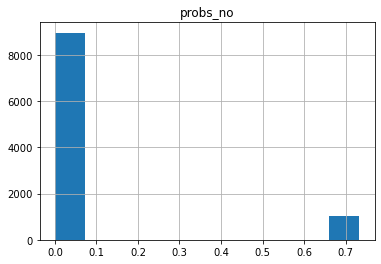

In [355]:
predictions.hist()

array([[<AxesSubplot:title={'center':'calibrated_predictions'}>]],
      dtype=object)

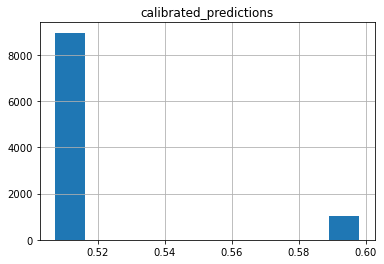

In [356]:
pd.DataFrame(predictions_probs, columns=['calibrated_predictions']).hist()

array([[<AxesSubplot:title={'center':'no'}>]], dtype=object)

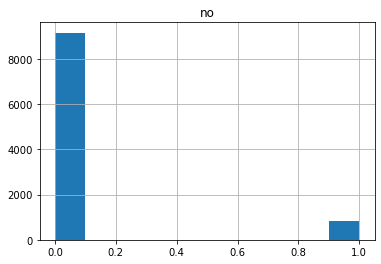

In [357]:
targets.hist()

### Check calibration of test data

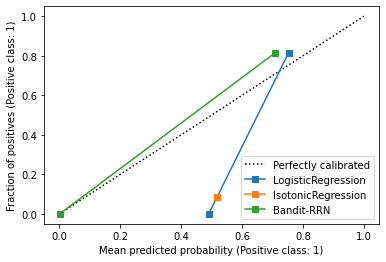

In [358]:
disp = CalibrationDisplay.from_estimator(calibrator, predictions, targets)
disp = CalibrationDisplay.from_predictions(targets, predictions_probs, ax=disp.ax_, name="IsotonicRegression")
disp = CalibrationDisplay.from_predictions(targets, predictions, ax=disp.ax_, name="Bandit-RRN")
plt.show()

# Inspecting the Model

### Global Explain

A global explanation prints the logic learned for each class.  The `quantile` parameter is the percent of the model you would like to be explained.

We represent our features as values scaled between 0 and 1.  Therefore, we intepret the explanations to mean that large values for a particular feature represent `truthiness` of a predicate, while small values represent `falseness` of a predicate.

#### Print Types

The explanation and printing methods can all be set to use different `print_type` parameters.  Each will produce a different style of explanation that may be used for different end-users.

`logical`: produces a logic statement format such as:

    AND(x1, x2)
    
`logical-natural`: produces a natural language formatted nested tree format, such as:

    the following are TRUE:
        - x1
        - x2
        
`natural`: produces a natural lanugage paragraph indicating the most important logics, to the least important logics, such as:

    Each one of the following must be met.  x1, and x2.


In [359]:
data.target_names

['no', 'yes']

In [360]:
print(best_model.explain(
    quantile=1.0,
    required_output_thresholds=np.array(0.75),
    explain_type='both',
    print_type='logical', 
    explanation_prefix="Machine fault was",
    target_names=['not detected'],
    ignore_uninformative=True,
    rounding_precision=4,
    decision_boundary=0.25,
    inverse_transform=mms.inverse_transform
))

Machine fault was not detected because: 

AND 


In [374]:
print(best_model.explain(
    quantile=1.0,
    required_output_thresholds=np.array(0.5),
    explain_type='both',
    print_type='logical-natural', 
    explanation_prefix="The machine fault was",
    target_names=['not detected'],
    ignore_uninformative=True,
    rounding_precision=3,
    decision_boundary=0.5,
    inverse_transform=mms.inverse_transform
))

The machine fault was not detected because: 

All the following are true: 


### Sample Explain

A sample explanation prints the logic that was used for a particular sample's predition. The `quantile` parameter is the percent of the model you would like to be explained.

In [375]:
#val_dataset[:10]

In [363]:
print(best_model.explain_samples(
            val_dataset[0]['features'].unsqueeze(0),
            quantile=1.0,
            target_names=['not detected'], 
            explain_type='both',
            sample_explanation_prefix="The machine fault was",
            print_type='logical-natural',
            ignore_uninformative=True,
            rounding_precision=3,
            decision_boundary=0.8,
            inverse_transform=mms.inverse_transform,
            min_max_feature_dict={col: {'min': data.data[:, i].min(), 'max': data.data[:, i].max()} for i, col in enumerate(list(data.feature_names))},
            simplify=True,
            exclusions=None
))

0: The machine fault was not not detected because: 


All the following are true: 
	The energy_consumption was less than 5 (100th percentile)
	The humidity was less than 79.312 (98th percentile)
	The machine_status was less than 1 (50th percentile)
	The temperature was between 65.868 and 67.459 (35th and 36th percentiles)
	The vibration was greater than or equal to 30.688 (36th percentile)


In [365]:
print(best_model.explain_samples(
    val_dataset[3]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['not detected'], 
    explain_type='both',
    sample_explanation_prefix="The machine fault was",
    print_type='logical-natural',
    ignore_uninformative=True,
    rounding_precision=3,
    decision_boundary=0.,
    inverse_transform=mms.inverse_transform,
    min_max_feature_dict={col: {'min': data.data[:, i].min(), 'max': data.data[:, i].max()} for i, col in enumerate(list(data.feature_names))},
    simplify=True,
    exclusions=None
))

0: The machine fault was not detected because: 


All the following are true: 
	The humidity was greater than or equal to 59.121 (58th percentile)
	The machine_status was greater than or equal to 1.99 (99th percentile)
	The temperature was greater than or equal to 45.529 (11th percentile)


### Printing the weights

We can inspect the weights the model learned for each logic to see how important they are to the overall prediction.

In [366]:
best_model.print_samples(
    val_dataset[0]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['not detected'], 
    explain_type='both',
    print_type='logical',
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: negative of not detected
Logic at depth 2: the humidity was >= 79.312, the machine_status was >= 1.0, the temperature was >= 67.459
output: tensor([0.5000, 0.3686, 0.9856])

Logic at depth 1: ['NOT(OR(the humidity was >= 79.312, the machine_status was >= 1.0, the temperature was >= 67.459))']
weights: tensor([-1.2098, -0.0243, -0.0298])
output: 0.3793398141860962
required_threshold: 0.3793591856956482

Logic at depth 2: NOT(the energy_consumption was >= 5.0), the temperature was >= 65.868, the vibration was >= 30.688
output: tensor([0.6889, 0.3686, 0.3954])

Logic at depth 1: ['OR(NOT(the energy_consumption was >= 5.0), the temperature was >= 65.868, the vibration was >= 30.688)']
weights: tensor([ 0.0003, -0.0051, -0.0029])
output: 0.005153846461325884
required_threshold: 0.0052430033683776855

Logic at depth 0: ['AND(NOT(OR(the humidity was >= 79.312, the machine_status was >= 1.0, the temperature was >= 67.459)), OR(NOT(the energy_consumption was >= 5.0)

In [367]:
best_model.print_samples(
    val_dataset[3]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['not detected'], 
    explain_type='both',
    print_type='logical',
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    inverse_transform=mms.inverse_transform,
)

REASONING NETWORK MODEL FOR: not detected
Logic at depth 2: NOT(the humidity was >= 59.121), NOT(the machine_status was >= 1.99), NOT(the temperature was >= 45.529)
output: tensor([1.0000, 0.3631, 0.7840])

Logic at depth 1: ['NOT(OR(NOT(the humidity was >= 59.121), NOT(the machine_status was >= 1.99), NOT(the temperature was >= 45.529)))']
weights: tensor([-1.2098, -0.0243, -0.0298])
output: 0.9781167507171631
required_threshold: 0.9721106886863708

Logic at depth 2: NOT(the temperature was >= 121.94), NOT(the vibration was >= 113.8), the energy_consumption was >= 0.5
output: tensor([0.3844, 0.3631, 0.5469])

Logic at depth 1: ['OR(NOT(the temperature was >= 121.94), NOT(the vibration was >= 113.8), the energy_consumption was >= 0.5)']
weights: tensor([ 0.0003, -0.0051, -0.0029])
output: 0.004655619617551565
required_threshold: 0.0

Logic at depth 0: ['AND(NOT(OR(NOT(the humidity was >= 59.121), NOT(the machine_status was >= 1.99), NOT(the temperature was >= 45.529))), OR(NOT(the temp

In [376]:
best_model.print(
    quantile=1.0,
    required_output_thresholds=torch.tensor(0.8),
    explain_type='both',
    print_type='logical', 
    target_names=['not detected'],
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    # inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: not detected
Logic at depth 2: NOT(the machine_status was >= 0.975), NOT(the temperature was >= 0.001)
output: tensor([0.9750, 0.0070, 0.0000])

Logic at depth 1: ['NOT(OR(NOT(the machine_status was >= 0.975), NOT(the temperature was >= 0.001)))']
weights: tensor([-1.2098, -0.0243, -0.0298])
output: 0.9160000085830688
required_threshold: 0.9157207608222961

Logic at depth 2: NOT(the temperature was >= 0.0), NOT(the vibration was >= 0.0), the energy_consumption was >= 1.0
output: tensor([1., 0., 0.])

Logic at depth 1: ['OR(NOT(the temperature was >= 0.0), NOT(the vibration was >= 0.0), the energy_consumption was >= 1.0)']
weights: tensor([ 0.0003, -0.0051, -0.0029])
output: 0.6159999966621399
required_threshold: 0.6147159934043884

Logic at depth 0: ['AND(NOT(OR(NOT(the machine_status was >= 0.975), NOT(the temperature was >= 0.001))), OR(NOT(the temperature was >= 0.0), NOT(the vibration was >= 0.0), the energy_consumption was >= 1.0))']
weights: tensor([-

In [377]:
best_model.print(
    quantile=1.0,
    required_output_thresholds=torch.tensor(0.6),
    explain_type='both',
    print_type='logical', 
    target_names=['not detected'],
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    # inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: negative of not detected
Logic at depth 2: the humidity was >= 1.0, the machine_status was >= 0.906, the temperature was >= 1.0
output: tensor([0.0940, 0.0000, 0.0000])

Logic at depth 1: ['NOT(OR(the humidity was >= 1.0, the machine_status was >= 0.906, the temperature was >= 1.0))']
weights: tensor([-1.2098, -0.0243, -0.0298])
output: 0.8320000171661377
required_threshold: 0.8325289487838745

Logic at depth 2: NOT(the energy_consumption was >= 1.0), the temperature was >= 0.0, the vibration was >= 0.0
output: tensor([0., 1., 1.])

Logic at depth 1: ['OR(NOT(the energy_consumption was >= 1.0), the temperature was >= 0.0, the vibration was >= 0.0)']
weights: tensor([ 0.0003, -0.0051, -0.0029])
output: 0.22699999809265137
required_threshold: 0.22943198680877686

Logic at depth 0: ['AND(NOT(OR(the humidity was >= 1.0, the machine_status was >= 0.906, the temperature was >= 1.0)), OR(NOT(the energy_consumption was >= 1.0), the temperature was >= 0.0, the vibra

In [378]:
best_model.print(
    quantile=1.0,
    required_output_thresholds=torch.tensor(0.6),
    explain_type='both',
    print_type='logical-natural',
    target_names=['not detected'],
    ignore_uninformative=False,
    rounding_precision=3,
    decision_boundary=0.7,
    # inverse_transform=mms.inverse_transform
)

REASONING NETWORK MODEL FOR: negative of not detected
Logic at depth 2: the humidity was greater than or equal to 1.0, the machine_status was greater than or equal to 0.906, the temperature was greater than or equal to 1.0
output: tensor([0.0940, 0.0000, 0.0000])

Logic at depth 1: ['NOT the following: \n\t- ANY of the following are TRUE: \n\t\t- the humidity was greater than or equal to 1.0, \n\t\t- the machine_status was greater than or equal to 0.906, \n\t\t- the temperature was greater than or equal to 1.0']
weights: tensor([-1.2098, -0.0243, -0.0298])
output: 0.8320000171661377
required_threshold: 0.8325289487838745

Logic at depth 2: NOT the energy_consumption was greater than or equal to 1.0, the temperature was greater than or equal to 0.0, the vibration was greater than or equal to 0.0
output: tensor([0., 1., 1.])

Logic at depth 1: ['ANY of the following are TRUE: \n\t- NOT the energy_consumption was greater than or equal to 1.0, \n\t- the temperature was greater than or equa